# Projet Representation Learning
Réalisé par Aimé MIAKASSISSA, Audrey MONSIMER et Sara TOUZANI.

 Le but de ce projet est de mettre en place un classifieur capable de prédire l'archétype d'un nouveau document.

 L'article *Hierarchical Convolutional Attention Networks for Text Classification (ACLC 2018)*
https://www.aclweb.org/anthology/W18-3002/
présente un réseau convolutionnel hiérarchique avec mécanisme d'attention. Ce projet va donc permettre d'approcher cette méthode.

Ce notebook va s'articuler de la manière suivante :
- Présentation du corpus
- Un premier réseau convolutif
- Un second réseau convolutif avec mécanisme hiérarchique d'attention. Ce réseau est celui qui se rapproche le plus de notre objectif




## Importation des modules
Comme nous travaillons sur Google Colab, cette première cellule permet d'aller chercher les fichiers et documents dans le drive.

Par ailleurs, *fasttext* n'est pas installé sur Colab, nous proposons donc l'installation de celui-ci.

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')
path_ = '/content/gdrive/My Drive/Projet_representation_learning/'

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
!pip install fasttext


In [ ]:
import numpy as np
import io
from os import path
import string
import numpy as np
import re
import fasttext
import pandas
from keras import backend as K
import tensorflow as tf

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import balanced_accuracy_score

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression

from keras.constraints import max_norm
from keras.initializers import glorot_normal
from keras.utils import plot_model
import nltk
from keras.preprocessing.sequence import pad_sequences
nltk.download('punkt')
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from keras.models import Model
from keras.layers import Input, Embedding, Conv1D, GlobalMaxPooling1D, Concatenate, Dense, Activation, Dropout , concatenate



from keras.layers import Flatten
from scipy.special import softmax

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


## Chargement du corpus

In [ ]:
path_ = '/content/gdrive/My Drive/Projet_representation_learning/'

In [ ]:

corpus = pandas.read_excel(path_+"corpus.xlsx")
texts = corpus["Campaign Text"]
labels = corpus["LEAD ARCHETYPE"]
corpus.shape, texts


((212, 3), 0      SPONSOR CONTENT BY Prudential\nA millennial’s ...
 1      PASSAGE TO INSPIRATION\nPAID PROGRAM\nDESIGN T...
 2      SPECIAL ADVERTISING FEATURE\nSponsored by HP\n...
 3      Bring the wellness trend to your bedroom with ...
 4      IN PARTNERSHIP WITH NETFLIX\n5 Hilariously Bad...
                              ...                        
 207    PAID PROGRAM\nLOGISTICS REPORT\nSuccess Withou...
 208    EXPERIENTIAL\nJOURNEYS\nA JOURNEY INTO INDIA, ...
 209    Mr. Mateusz Morawiecki - the new Prime Ministe...
 210    PAID FOR AND POSTED BY SOTHEBY’S INTERNATIONAL...
 211    Inside The Egyptian Community Thriving In Mode...
 Name: Campaign Text, Length: 212, dtype: object)

Le corpus est séparé en 2 :
- partie training, qui contient les 160 premiers textes
- partie test qui contient le reste, à savoir 52 textes

In [ ]:
train_texts = texts[:160]
test_texts = texts[160:]
train_labels = labels[:160]
test_labels = labels[160:]

## Classifieur bayésien naïf multinomial

In [ ]:

vectorizer = CountVectorizer(lowercase=True, 
                             ngram_range=(1, 3), 
                             analyzer="word", 
                             min_df=4, 
                             max_df=0.2,
                             max_features=20000)
train_dtm = vectorizer.fit_transform(train_texts)
mnb = MultinomialNB(alpha=0.1, fit_prior=True)
mnb.fit(train_dtm, train_labels)
test_dtm = vectorizer.transform(test_texts)
balanced_accuracy_score(mnb.predict(test_dtm), test_labels)

0.7482142857142857

## Classifieur basé sur la régression logistique

In [ ]:

weighted_vectorizer = TfidfVectorizer(lowercase=True, 
                                      ngram_range=(1, 3), 
                                      analyzer="word", 
                                      min_df=4, 
                                      max_df=0.2,
                                      max_features=20000,
                                      sublinear_tf=True)
train_weighted_dtm = weighted_vectorizer.fit_transform(train_texts)
lr = LogisticRegression(penalty="elasticnet", C=10, solver="saga", l1_ratio=0.4, max_iter=1000)
lr.fit(train_weighted_dtm, train_labels)
test_weighted_dtm = weighted_vectorizer.transform(test_texts)
balanced_accuracy_score(lr.predict(test_weighted_dtm), test_labels)

0.7891483516483517

## Création du vocabulaire

In [ ]:
text=''
for elm in train_texts:
    text+=elm
 

In [ ]:
vocabulary=set()
clean_unicode = {
    'http[\s|:|/|s]*[\w|.|/|\d]*':"",
    "[^\x01-\x7F]":" ",
    "HJuly":"July",
    "'s":" ",
#    '\w+s':" ",
    '[ \s\t\n\r\f\v]+':" ",
    "\W":" ",
    '[ \s\t\n\r\f\v]+':" "




}

def process_txts(texts, update_vocabulary):
    articles = []

    for article in texts:
      parsed = process_article(article, update_vocabulary)
      articles.append(parsed)
    return articles



def process_article(article, update_vocabulary):

    txt_propre = article
    for c in clean_unicode:
        txt_propre = re.sub(c, clean_unicode[c], txt_propre.lower())
        
    tokens_clean=txt_propre.split(' ')
    tokens_clean=[token for token in tokens_clean if token!=""]

    if update_vocabulary:
        for token in set(tokens_clean):
            vocabulary.add(token)
    return tokens_clean



train_data = process_txts(train_texts, update_vocabulary=True)
test_data=process_txts(test_texts,update_vocabulary=True)



On utilise les mots de fasttext afin d'avoir la représentation des mots. Pour ce faire, on a choisi d'utiliser SkipGram arbitrairement.


In [ ]:
# Skipgram model :
model_skipgram = fasttext.train_unsupervised(path_+'MergedText.txt', model='skipgram')
# or, cbow model :
#model_cbow = fasttext.train_unsupervised(path_+'texts.txt', model='cbow')

On supprime les mots dont nous n'avons la représentation (les mots contenus dans notre vocabulaire qui ne sont pas dans le model SkipGram).

In [ ]:
unknown_words = (set(sorted([word for word in vocabulary if word not in model_skipgram.words])))
vocabulary2 = list(vocabulary - unknown_words)
word_map = {}
word_vectors = np.zeros((len(vocabulary2) + 2, 100))

for i in range(len(vocabulary2)):
    word_map[vocabulary2[i]] = i
    word_vectors[i] = model_skipgram[vocabulary2[i]]
word_vectors[len(vocabulary2)] = np.random.uniform(low=-0.1, high=0.1, size=100)
word_vectors[len(vocabulary2) + 1] = np.random.uniform(low=-0.1, high=0.1, size=100)
default_index = len(vocabulary2)

Redimensionnement des données en 2 dimensions afin de les donner en input du modèle. On choisit de garder 1000 mots par document.

In [ ]:
from keras.preprocessing.sequence import pad_sequences

def get_index(word):
    return word_map.get(word, default_index)

def format_articles(sentences, max_length=None):
    if max_length == None:
        max_length = max([len(sentence) for sentence in sentences])
    indexes = [[get_index(t) for t in sentence] for sentence in sentences]
    sequences = pad_sequences(indexes, 
                              maxlen=max_length, 
                              dtype='int32', 
                              padding='post', 
                              truncating='pre',
                              value=len(vocabulary2)+1) # id pour les tokens "hors phrase"    

    return max_length,sequences

max_length, train_input = format_articles(train_data,1000)
_,test_input=format_articles(test_data,max_length)



In [ ]:
len(word_map),len(vocabulary2)


(4923, 4923)

In [ ]:
train_input.shape

(160, 1000)

# Classifieur Réseau CNN  

Création de l'architecture du modèle avec différents filtres de différentes largeurs.


In [ ]:
from keras.models import Model
import matplotlib.pyplot as plt
from keras.layers import Input, Embedding, Conv1D, GlobalMaxPooling1D, concatenate, Dense, Activation, Dropout
from keras.constraints import max_norm
from keras.initializers import glorot_normal
from keras.utils import plot_model
%matplotlib inline

# Initialisation du modèle
n_positions = 2 * max_length - 1
position_vectors = np.random.uniform(low=-0.1, high=0.1, size=(n_positions, 50))


W=word_vectors
P=position_vectors
n_filters=150
filter_sizes=[2, 3, 4, 5]
activation="tanh"
p=0.5
clip=3.
train_word_vectors=True

#######
# Configuration de l'entée
input_words = Input(shape=(max_length,), name="words")


# Configuration de la couche de représentation des mots - statique
word_embedding = Embedding(input_dim=len(vocabulary2)+2, # taille du vocabulaire
                            output_dim=100, # dimension de l'espace d'embedding des mots
                            input_length=max_length, # longeur maximale des textes
                            weights=[W], 
                            trainable=train_word_vectors,
                            name="word_embedding")(input_words)

# Concaténation des représentations des mots et des représentations des positions
merge_embedding = word_embedding

# Configuration des couches de convolution en parallèle, avec max pooling 
parallel = []
for size in filter_sizes:
    convolution = Conv1D(n_filters, # nombre de filtres
                          kernel_size=size, # taille des filtres
                          padding="valid", 
                          activation=activation,
                          name="convolution_%d" % size)(merge_embedding)
    pooling = GlobalMaxPooling1D(name="max_pooling_%d" % size)(convolution)
    parallel.append(pooling)

# Concaténation des sorties des couches de max pooling parallèles, avec dropout
merge_convolution = concatenate(parallel, name="concatenate_pooling")
overall_pooling = Dropout(p, name="dropout")(merge_convolution)

# Configuration de la couche de classification
classification = Dense(4, 
                        activation='softmax', 
                        kernel_initializer=glorot_normal(seed=1),
                        bias_initializer='zeros',
                        kernel_constraint=max_norm(clip), 
                        name="classification")(overall_pooling)

model=Model(inputs=input_words,outputs=classification)

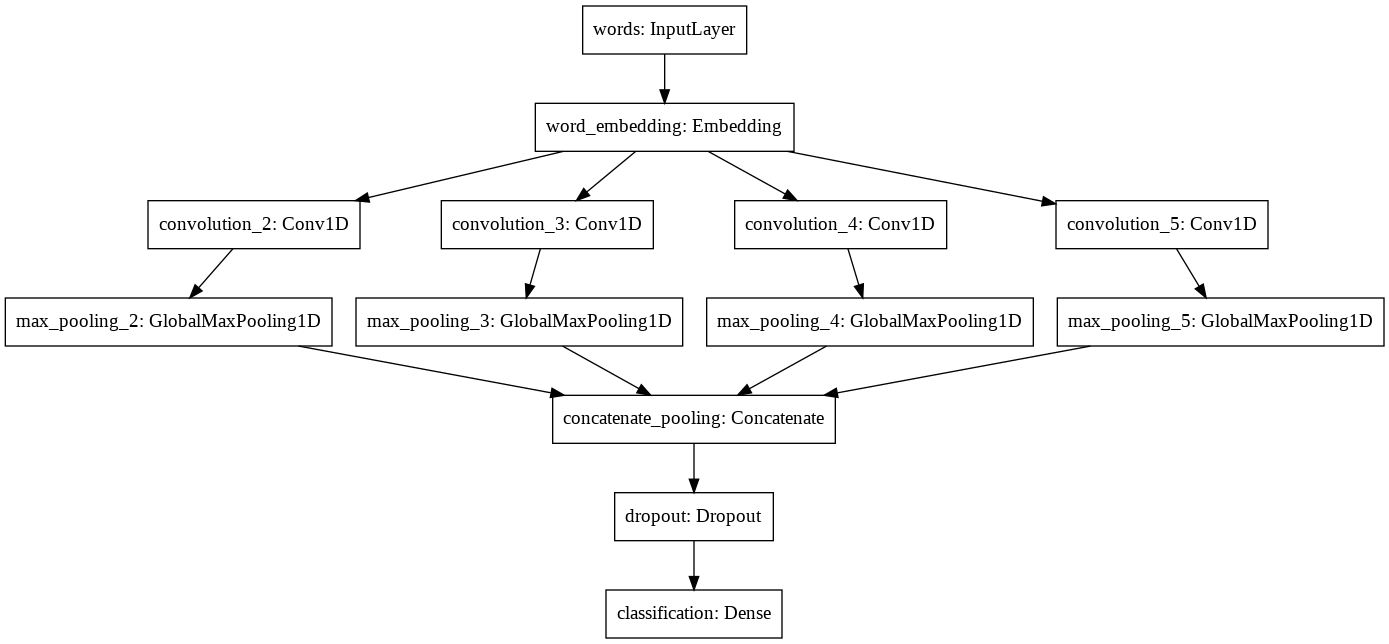

In [ ]:
plot_model(model)

## Entrainement du réseau

On entraine sur 30 epochs avec un batch size de 100.

In [ ]:
from sklearn.preprocessing import OneHotEncoder

label_encoder = OneHotEncoder()


# Définition de l'objectif à minimiser

model.compile(loss='categorical_crossentropy',
                optimizer='adadelta',
                metrics=['accuracy'])

# Optimisation
log = model.fit(train_input,
                label_encoder.fit_transform((np.array(train_labels).reshape(160, 1))),
                batch_size=100,
                epochs=30,
                validation_data=(test_input, 
                                 label_encoder.fit_transform((np.array(test_labels).reshape(52, 1)))))


Train on 160 samples, validate on 52 samples
Epoch 1/30
160/160 [==============================] - 7s 41ms/step - loss: 0.5022 - acc: 0.8188 - val_loss: 1.4030 - val_acc: 0.4423
Epoch 2/30
160/160 [==============================] - 5s 34ms/step - loss: 0.5656 - acc: 0.8000 - val_loss: 1.3427 - val_acc: 0.3462
Epoch 3/30
160/160 [==============================] - 5s 33ms/step - loss: 0.4473 - acc: 0.8437 - val_loss: 1.3403 - val_acc: 0.4231
Epoch 4/30
160/160 [==============================] - 5s 33ms/step - loss: 0.4367 - acc: 0.8938 - val_loss: 1.4368 - val_acc: 0.4231
Epoch 5/30
160/160 [==============================] - 5s 33ms/step - loss: 0.4823 - acc: 0.8437 - val_loss: 1.3571 - val_acc: 0.4231
Epoch 6/30
160/160 [==============================] - 5s 33ms/step - loss: 0.4521 - acc: 0.8563 - val_loss: 1.2600 - val_acc: 0.5000
Epoch 7/30
160/160 [==============================] - 5s 33ms/step - loss: 0.3647 - acc: 0.8938 - val_loss: 1.2647 - val_acc: 0.4615
Epoch 8/30
160/160 [====

Graphique de la précision du modèle.

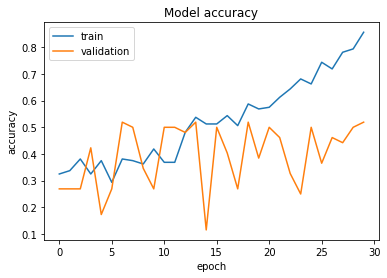

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline


# Visualisation des courbes d'apprentissage
plt.plot(log.history['acc'])
plt.plot(log.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

# Classifieur Réseau HCAN (Hierarchical Convolutional Attention Networks)

In [ ]:
import pandas
import io
from os import path
import string
import numpy as np
import re
import nltk
from keras.preprocessing.sequence import pad_sequences
nltk.download('punkt')
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from keras.models import Model
from keras.layers import Input, Embedding, Conv1D, GlobalMaxPooling1D, Concatenate, Dense, Activation, Dropout , concatenate
from keras.constraints import max_norm
from keras.initializers import glorot_normal
from keras.utils import plot_model
from keras.layers import Flatten
from scipy.special import softmax
from keras import backend as K
import tensorflow as tf
import numpy as np
from keras.layers import Lambda

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [ ]:
n_positions = 2 * max_length - 1
position_vectors = np.random.uniform(low=-0.1, high=0.1, size=(n_positions, 50))


W=word_vectors
P=position_vectors
n_filters=150
filter_sizes=[2, 3, 4, 5]
activation="tanh"
p=0.5
clip=3.
train_word_vectors=True

#######
# Configuration de l'entée
input_words = Input(shape=(max_length,), name="words")


# Configuration de la couche de représentation des mots - statique
word_embedding = Embedding(input_dim=len(vocabulary2)+2, # taille du vocabulaire
                            output_dim=100, # dimension de l'espace d'embedding des mots
                            input_length=max_length, # longeur maximale des textes
                            weights=[W], 
                            trainable=train_word_vectors,
                            name="word_embedding")(input_words)

# Concaténation des représentations des mots et des représentations des positions
merge_embedding = word_embedding

# Configuration des couches de convolution Q Key V avec elu


Q = Conv1D(n_filters, # nombre de filtres
                          kernel_size=3, # taille des filtres
                          padding="valid", 
                          activation='elu',
                          name="Q")(word_embedding)
Key = Conv1D(n_filters, # nombre de filtres
                          kernel_size=3, # taille des filtres
                          padding="valid", 
                          activation='elu',
                          name="Key")(word_embedding)
V = Conv1D(n_filters, # nombre de filtres
                          kernel_size=3, # taille des filtres
                          padding="valid", 
                          activation='elu',
                          name="V")(word_embedding)

# Concaténation des sorties des couches de max pooling parallèles, avec dropout
Multi = Lambda(lambda x: tf.matmul(x[0], x[1], transpose_b=True,name="Produit_Q_K"))([Q, Key])
qk=Lambda(lambda x: tf.math.divide(x, np.sqrt(300)))(Multi)
soft=Lambda(lambda x: tf.nn.softmax(x,name="softmax"))(qk)
head_elu = Lambda(lambda x: tf.matmul(x[0], x[1], transpose_b=False,name="head1"))([soft, V])                          
############## Q1 Key2,V2 avec tanh

Q1 = Conv1D(n_filters, # nombre de filtres
                          kernel_size=3, # taille des filtres
                          padding="valid", 
                          activation='elu',
                          name="Q1")(word_embedding)
Key1 = Conv1D(n_filters, # nombre de filtres
                          kernel_size=3, # taille des filtres
                          padding="valid", 
                          activation='elu',
                          name="Key1")(word_embedding)
V1 = Conv1D(n_filters, # nombre de filtres
                          kernel_size=3, # taille des filtres
                          padding="valid", 
                          activation='tanh',
                          name="V1")(word_embedding)

# Concaténation des sorties des couches de max pooling parallèles, avec dropout
Multi1 = Lambda(lambda x: tf.matmul(x[0], x[1], transpose_b=True,name="Produit_Q_K"))([Q1, Key1])
qk1=Lambda(lambda x: tf.math.divide(x, np.sqrt(300)))(Multi1)
soft1=Lambda(lambda x: tf.nn.softmax(x,name="softmax"))(qk1)
head_tanh = Lambda(lambda x: tf.matmul(x[0], x[1], transpose_b=False,name="head"))([soft1, V1]) 
Multi=Lambda(lambda x:tf.multiply(x[0], x[1]))([head_tanh,head_elu])
#merge_convolution = concatenate([Q,Key,V], name="concatenate_pooling")
overall_pooling = Dropout(p, name="dropout")(Multi)
word_Norm=Lambda(lambda x:tf.keras.backend.l2_normalize(x))(overall_pooling) 


In [ ]:
from tensorflow.keras import layers


T=  Conv1D(n_filters,
                     kernel_size=3,
                      activation= "elu",
                      name="T" )(word_Norm)


K2 = Conv1D(n_filters,
                     kernel_size=3,
                      activation= "elu",
                      name="K" )(word_Norm)
V2 = Conv1D(n_filters,
                     kernel_size=3,
                      activation= "elu",
                      name="V2" )(word_Norm)

Multi1 = Lambda(lambda x: tf.matmul(x[0], x[1], transpose_b=True,name="Produit_Q_K"))([T, K2])
qk1=Lambda(lambda x: tf.math.divide(x, np.sqrt(150)))(Multi1)
soft1=Lambda(lambda x: tf.nn.softmax(x,name="softmax"))(qk1)
head_target = Lambda(lambda x: tf.matmul(x[0], x[1], transpose_b=False,name="head"))([soft1, V2]) 
overall_pooling = Dropout(0.5, name="dropout3")(head_target)
flatten_dim = Flatten()(overall_pooling)                    
# Configuration de la couche de classification
classification = Dense(4, 
                        activation='softmax', 
                        kernel_initializer=glorot_normal(seed=1),
                        bias_initializer='zeros',
                        kernel_constraint=max_norm(clip), 
                        name="classification")(flatten_dim)
model=Model(inputs=input_words,outputs=classification)



Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.



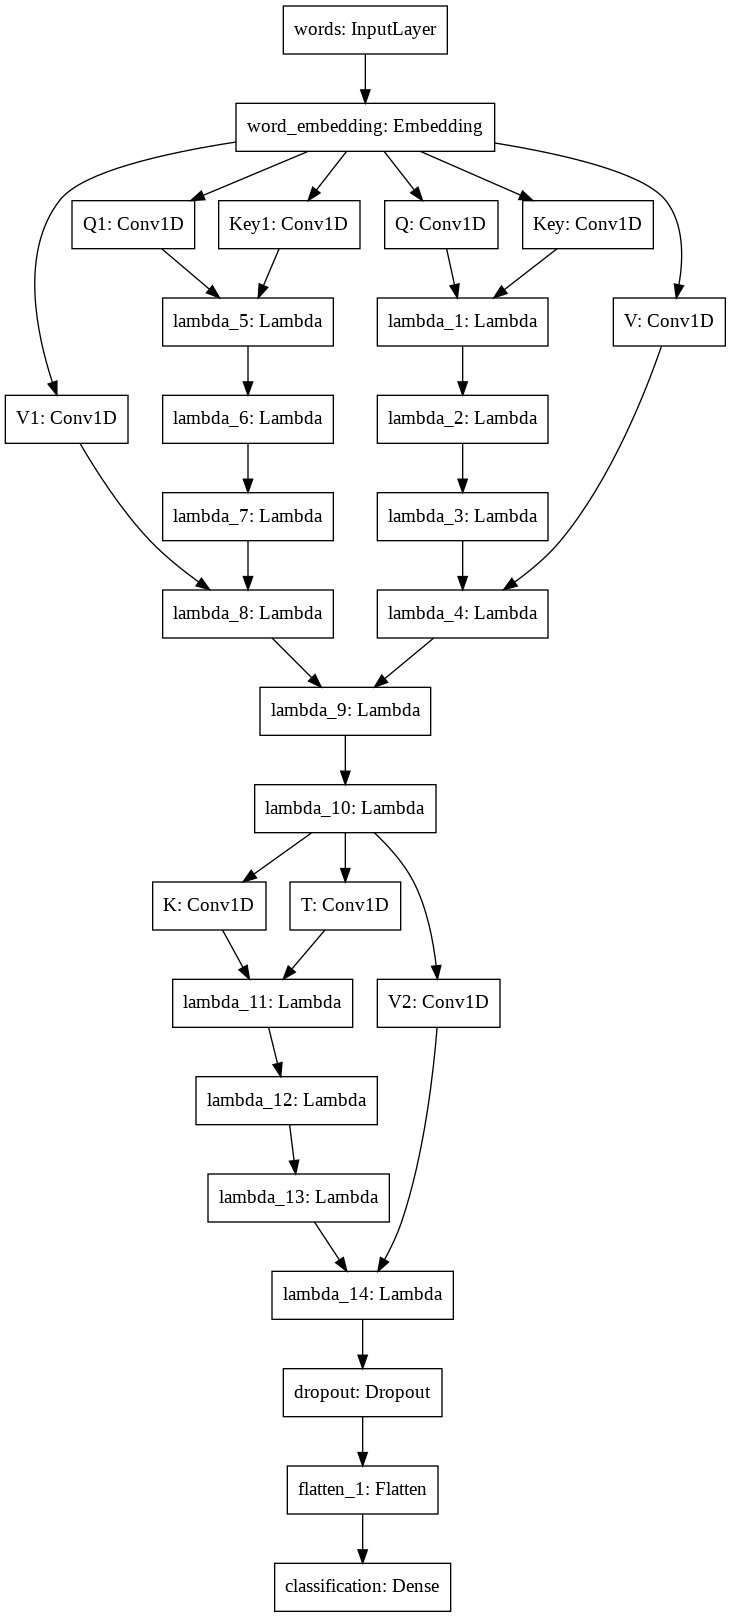

In [ ]:
plot_model(model)

In [ ]:
from sklearn.preprocessing import OneHotEncoder

label_encoder = OneHotEncoder()
model.compile(loss='categorical_crossentropy',
                optimizer='adadelta',
                metrics=['accuracy'])

# Optimisation
log = model.fit(train_input,
                label_encoder.fit_transform((np.array(train_labels).reshape(160, 1))),
                batch_size=100,
                epochs=10,
                validation_data=(test_input, 
                                 label_encoder.fit_transform((np.array(test_labels).reshape(52, 1)))))




Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Train on 160 samples, validate on 52 samples
Epoch 1/10
160/160 [==============================] - 37s 231ms/step - loss: 1.3848 - acc: 0.2750 - val_loss: 1.3460 - val_acc: 0.5192
Epoch 2/10
160/160 [==============================] - 35s 219ms/step - loss: 1.3484 - acc: 0.4125 - val_loss: 1.2005 - val_acc: 0.5192
Epoch 3/10
160/160 [==============================] - 34s 214ms/step - loss: 1.3175 - acc: 0.4125 - val_loss: 1.2664 - val_acc: 0.5192
Epoch 4/10
160/160 [==============================] - 34s 214ms/step - loss: 1.3501 - acc: 0.4125 - val_loss: 1.3507 - val_acc: 0.2692
Epoch 5/10
160/160 [==============================] - 35s 216ms/step - loss: 1.3506 - acc: 0.3250 - val_loss: 1.2154 - val_acc: 0.5192
Epoch 6/10
160/160 [==============================] - 34s 214ms/step - loss: 1.3177 - acc: 0.4125 - val_loss: 1.1831 - val_acc: 0.5192
Epoch 7/10
160/160 [===========================

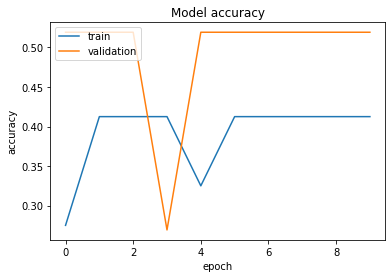

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline


# Visualisation des courbes d'apprentissage
plt.plot(log.history['acc'])
plt.plot(log.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [ ]:
n_positions = 2 * max_length - 1
position_vectors = np.random.uniform(low=-0.1, high=0.1, size=(n_positions, 50))


W=word_vectors
P=position_vectors
n_filters=150
filter_sizes=[2, 3, 4, 5]
activation="tanh"
p=0.5
clip=3.
train_word_vectors=True

#######
# Configuration de l'entée
input_words = Input(shape=(max_length,), name="words")


# Configuration de la couche de représentation des mots - statique
word_embedding = Embedding(input_dim=len(vocabulary2)+2, # taille du vocabulaire
                            output_dim=100, # dimension de l'espace d'embedding des mots
                            input_length=max_length, # longeur maximale des textes
                            weights=[W], 
                            trainable=train_word_vectors,
                            name="word_embedding")(input_words)

# Concaténation des représentations des mots et des représentations des positions
merge_embedding = word_embedding

# Configuration des couches de convolution Q Key V avec elu


Q = Conv1D(n_filters, # nombre de filtres
                          kernel_size=3, # taille des filtres
                          padding="valid", 
                          activation='elu',
                          name="Q")(word_embedding)
Key = Conv1D(n_filters, # nombre de filtres
                          kernel_size=3, # taille des filtres
                          padding="valid", 
                          activation='elu',
                          name="Key")(word_embedding)
V = Conv1D(n_filters, # nombre de filtres
                          kernel_size=3, # taille des filtres
                          padding="valid", 
                          activation='elu',
                          name="V")(word_embedding)

# Concaténation des sorties des couches de max pooling parallèles, avec dropout
Multi = Lambda(lambda x: tf.matmul(x[0], x[1], transpose_b=True,name="Produit_Q_K"))([Q, Key])
qk=Lambda(lambda x: tf.math.divide(x, np.sqrt(300)))(Multi)
soft=Lambda(lambda x: tf.nn.softmax(x,name="softmax"))(qk)
head_elu = Lambda(lambda x: tf.matmul(x[0], x[1], transpose_b=False,name="head1"))([soft, V])                          
############## Q1 Key2,V2 avec tanh

Q1 = Conv1D(n_filters, # nombre de filtres
                          kernel_size=3, # taille des filtres
                          padding="valid", 
                          activation='elu',
                          name="Q1")(word_embedding)
Key1 = Conv1D(n_filters, # nombre de filtres
                          kernel_size=3, # taille des filtres
                          padding="valid", 
                          activation='elu',
                          name="Key1")(word_embedding)
V1 = Conv1D(n_filters, # nombre de filtres
                          kernel_size=3, # taille des filtres
                          padding="valid", 
                          activation='tanh',
                          name="V1")(word_embedding)

# Concaténation des sorties des couches de max pooling parallèles, avec dropout
Multi1 = Lambda(lambda x: tf.matmul(x[0], x[1], transpose_b=True,name="Produit_Q_K"))([Q1, Key1])
qk1=Lambda(lambda x: tf.math.divide(x, np.sqrt(300)))(Multi1)
soft1=Lambda(lambda x: tf.nn.softmax(x,name="softmax"))(qk1)
head_tanh = Lambda(lambda x: tf.matmul(x[0], x[1], transpose_b=False,name="head"))([soft1, V1]) 
Multi=Lambda(lambda x:tf.multiply(x[0], x[1]))([head_tanh,head_elu])
#merge_convolution = concatenate([Q,Key,V], name="concatenate_pooling")
word_Norm=Lambda(lambda x:tf.keras.backend.l2_normalize(x))(Multi)
flatten_dim = Flatten()(word_Norm)                    
# Configuration de la couche de classification
classification = Dense(4, 
                        activation='softmax', 
                        kernel_initializer=glorot_normal(seed=1),
                        bias_initializer='zeros',
                        kernel_constraint=max_norm(clip), 
                        name="classification")(flatten_dim)
model2=Model(inputs=input_words,outputs=classification)

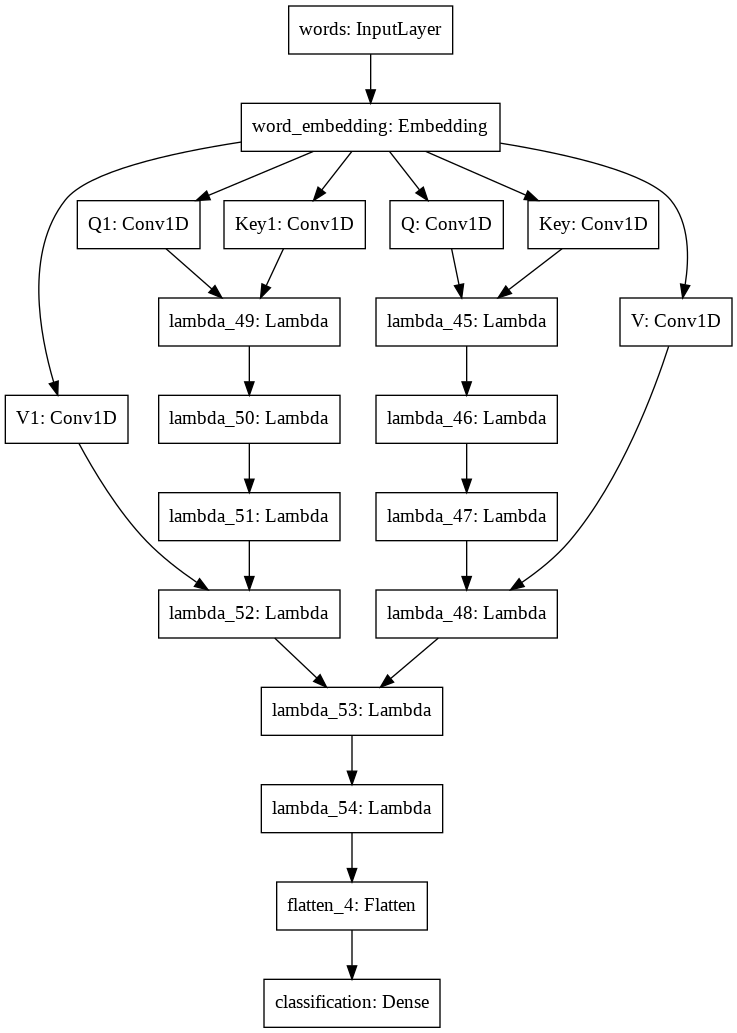

In [ ]:
plot_model(model2)

In [ ]:
from sklearn.preprocessing import OneHotEncoder

label_encoder = OneHotEncoder()
model2.compile(loss='categorical_crossentropy',
                optimizer='adadelta',
                metrics=['accuracy'])

# Optimisation
log = model2.fit(train_input,
                label_encoder.fit_transform((np.array(train_labels).reshape(160, 1))),
                batch_size=100,
                epochs=5,
                validation_data=(test_input, 
                                 label_encoder.fit_transform((np.array(test_labels).reshape(52, 1)))))


Train on 160 samples, validate on 52 samples
Epoch 1/5
160/160 [==============================] - 23s 147ms/step - loss: 1.3603 - acc: 0.4125 - val_loss: 1.3413 - val_acc: 0.5192
Epoch 2/5
160/160 [==============================] - 22s 135ms/step - loss: 1.3567 - acc: 0.4125 - val_loss: 1.3365 - val_acc: 0.5192
Epoch 3/5
160/160 [==============================] - 22s 137ms/step - loss: 1.3543 - acc: 0.4125 - val_loss: 1.3321 - val_acc: 0.5192
Epoch 4/5
160/160 [==============================] - 22s 135ms/step - loss: 1.3502 - acc: 0.4125 - val_loss: 1.3271 - val_acc: 0.5192
Epoch 5/5
160/160 [==============================] - 22s 135ms/step - loss: 1.3465 - acc: 0.4125 - val_loss: 1.3221 - val_acc: 0.5192


In [ ]:

n_positions = 2 * max_length - 1
position_vectors = np.random.uniform(low=-0.1, high=0.1, size=(n_positions, 50))


W=word_vectors
P=position_vectors
n_filters=150
filter_sizes=[2, 3, 4, 5]
activation="tanh"
p=0.5
clip=3.
train_word_vectors=True

#######
# Configuration de l'entée
input_words = Input(shape=(max_length,), name="words")


# Configuration de la couche de représentation des mots - statique
word_embedding = Embedding(input_dim=len(vocabulary2)+2, # taille du vocabulaire
                            output_dim=100, # dimension de l'espace d'embedding des mots
                            input_length=max_length, # longeur maximale des textes
                            weights=[W], 
                            trainable=train_word_vectors,
                            name="word_embedding")(input_words)

# split des représentations des mots et des représentations des positions
words_embedding_splited=Lambda(lambda x: tf.split(x, 2, -1))(word_embedding)

# Configuration des couches de convolution Q Key V avec elu


Q = Conv1D(n_filters, # nombre de filtres
                          kernel_size=3, # taille des filtres
                          padding="valid", 
                          activation='elu',
                          name="Q")(words_embedding_splited[0])
Key = Conv1D(n_filters, # nombre de filtres
                          kernel_size=3, # taille des filtres
                          padding="valid", 
                          activation='elu',
                          name="Key")(words_embedding_splited[0])
V = Conv1D(n_filters, # nombre de filtres
                          kernel_size=3, # taille des filtres
                          padding="valid", 
                          activation='elu',
                          name="V")(words_embedding_splited[0])

Multi = Lambda(lambda x: tf.matmul(x[0], x[1], transpose_b=True,name="Produit_Q_K"))([Q, Key])
qk=Lambda(lambda x: tf.math.divide(x, np.sqrt(300)))(Multi)
soft=Lambda(lambda x: tf.nn.softmax(x,name="softmax"))(qk)
head_elu1 = Lambda(lambda x: tf.matmul(x[0], x[1], transpose_b=False,name="head1"))([soft, V])   

Q11 = Conv1D(n_filters, # nombre de filtres
                          kernel_size=3, # taille des filtres
                          padding="valid", 
                          activation='elu',
                          name="Q11")(words_embedding_splited[1])
Key11= Conv1D(n_filters, # nombre de filtres
                          kernel_size=3, # taille des filtres
                          padding="valid", 
                          activation='elu',
                          name="Key11")(words_embedding_splited[1])
V11 = Conv1D(n_filters, # nombre de filtres
                          kernel_size=3, # taille des filtres
                          padding="valid", 
                          activation='elu',
                          name="V11")(words_embedding_splited[1])

Multi = Lambda(lambda x: tf.matmul(x[0], x[1], transpose_b=True,name="Produit_Q_K1"))([Q11, Key11])
qk=Lambda(lambda x: tf.math.divide(x, np.sqrt(300)))(Multi)
soft=Lambda(lambda x: tf.nn.softmax(x,name="softmax"))(qk)
head_elu2 = Lambda(lambda x: tf.matmul(x[0], x[1], transpose_b=False,name="head11"))([soft, V11])                          

Multihead_elu = concatenate([head_elu1,head_elu2], name="Multihead_Self_Attention_elu", axis=-1)

flatten_dim = Flatten()(Multihead_elu)                    
# Configuration de la couche de classification
classification = Dense(4, 
                        activation='softmax', 
                        kernel_initializer=glorot_normal(seed=1),
                        bias_initializer='zeros',
                        kernel_constraint=max_norm(clip), 
                        name="classification")(flatten_dim)
model2=Model(inputs=input_words,outputs=classification)

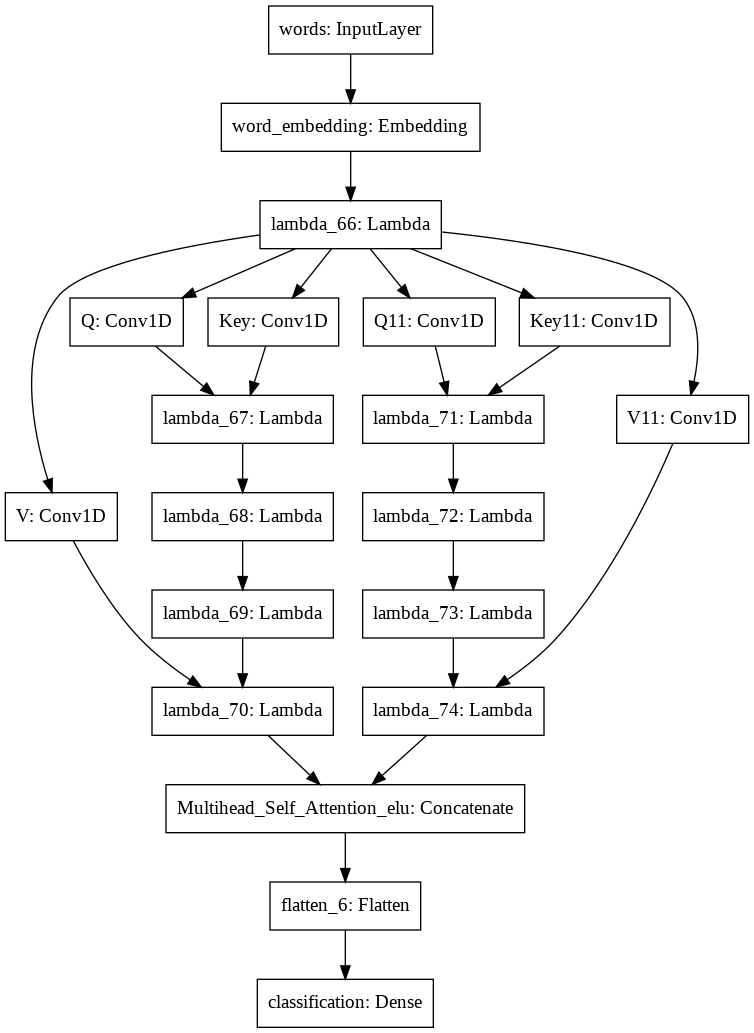

In [ ]:
plot_model(model2)

In [ ]:
from sklearn.preprocessing import OneHotEncoder

label_encoder = OneHotEncoder()
model2.compile(loss='categorical_crossentropy',
                optimizer='adadelta',
                metrics=['accuracy'])

# Optimisation
log = model2.fit(train_input,
                label_encoder.fit_transform((np.array(train_labels).reshape(160, 1))),
                batch_size=100,
                epochs=10,
                validation_data=(test_input, 
                                 label_encoder.fit_transform((np.array(test_labels).reshape(52, 1)))))


Train on 160 samples, validate on 52 samples
Epoch 1/10
160/160 [==============================] - 21s 132ms/step - loss: 4.0781 - acc: 0.5000 - val_loss: 3.9327 - val_acc: 0.3077
Epoch 2/10
160/160 [==============================] - 19s 118ms/step - loss: 3.3760 - acc: 0.4438 - val_loss: 2.8576 - val_acc: 0.3846
Epoch 3/10
160/160 [==============================] - 19s 118ms/step - loss: 2.6142 - acc: 0.5250 - val_loss: 2.5371 - val_acc: 0.5962
Epoch 4/10
160/160 [==============================] - 19s 117ms/step - loss: 2.1464 - acc: 0.5187 - val_loss: 2.6817 - val_acc: 0.2692
Epoch 5/10
160/160 [==============================] - 19s 119ms/step - loss: 4.2430 - acc: 0.3500 - val_loss: 6.8138 - val_acc: 0.1154
Epoch 6/10
160/160 [==============================] - 19s 119ms/step - loss: 5.0508 - acc: 0.2687 - val_loss: 4.7821 - val_acc: 0.3846
Epoch 7/10
160/160 [==============================] - 19s 117ms/step - loss: 4.5784 - acc: 0.3812 - val_loss: 4.4022 - val_acc: 0.3654
Epoch 8/10

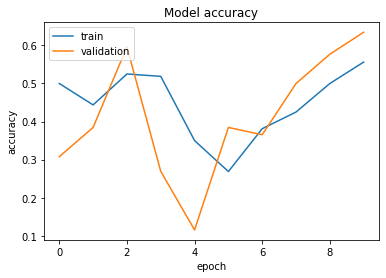

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline


# Visualisation des courbes d'apprentissage
plt.plot(log.history['acc'])
plt.plot(log.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

## Piste pour la hiérarchisation

In [ ]:
def format_sentences(article,max_length=None,max_sentence = None):
    if max_length == None:
        max_length = max([len(sentence) for sentence in article])
    tokens = nltk.sent_tokenize(article)
    nb_sentences = len(tokens)
    doc = np.zeros((nb_sentences,max_length))
    t=0
    for i in range(nb_sentences):
        tmp=tokens[i]
        tmp2 = nltk.wordpunct_tokenize(tmp)
        sentences = []
        for word in tmp2:
            sentences.append(get_index(word))
          
            sequences = pad_sequences([sentences], 
                              maxlen=max_length, 
                              dtype='int32', 
                              padding='post', 
                              truncating='pre',
                              value=len(vocabulary)+1) # id pour les tokens "hors phrase"
          
        doc[i,:] = sequences[0]
      
    if max_sentence == None:
        return doc
    
    
    return doc[:max_sentence,:]